In [1]:
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
# import math
# from networkx import minimum_cut, DiGraph
from mip import *
# from itertools import product

from src.read_instance import MDOVRP
# rnd = np.random
# rnd.seed(454)

In [2]:
# filepath = "Instancias/ES-n78-m2-Q10138.txt"
filepath = "Instancias/Vrp-Set-A/A-n80-m2-Q60.vrp"

In [3]:
N, D, V, Q, q, c, coord_x, coord_y = MDOVRP(filepath)
# N -> cidades
# D -> depositos
# V = N + D

In [4]:
# fazendo c ser simétrica
# c = {(i,j) : (c[i,j] + c[j, i])/2  for (i,j) in c}

Usando a formulação $MDOVRP_{2i− flv}$ de Lalla-Ruiz e Mes (2019)


    Lalla-Ruiz, Eduardo, and Martijn Mes. "Mathematical formulations and improvements for the multi-depot open vehicle routing problem." Optimization Letters 15 (2021): 271-286.

In [5]:
#cria o modelo
model = Model('PRVMD', solver_name = GUROBI)

# Variaveis de decisao
x = [[model.add_var(var_type=BINARY) if i!=j else model.add_var(lb=0, ub=0) for i in V] for j in V]
u = [[model.add_var(var_type=CONTINUOUS) if i!=j else model.add_var(lb=0, ub=0) for i in V] for j in V]
y = [model.add_var(var_type=BINARY) for i in N]
w = [model.add_var(var_type=BINARY) for i in N] # decide se cidade será atendida

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br


\begin{equation}
\label{eq:9}
    x_{ij} \in \{0, 1\}, \quad \forall i, j \in V
\end{equation}

\begin{equation}
\label{eq:10}
    u_{ij} \geq 0, \quad \forall i, j \in V
\end{equation}

In [6]:
# # Funcao objetivo
M = 1000
model.objective = minimize(xsum(x[i][j] * c[i,j] for i in V for j in V if i != j) - M*xsum(w[j] * q[j] for j in N))

\begin{equation}
\label{eq:1}
 Minimizar \quad \sum_{i \in V }\sum_{j \in V} c_{ij}x_{ij}
\end{equation}

In [7]:
# maximizar as demandas atendidas
# model.objective = maximize(xsum(w[j] * q[j] for j in N))

In [8]:
# tentando melhorar a solução encontrada
# model += xsum(x[i][j] * c[i,j] for i in V for j in V if i != j) <= 400 

In [9]:
# # Restricao 2
# for j in N:
#     model += xsum(x[i][j] for i in V if i != j) == 1

In [10]:
# Restricao se cidade pertencera a alguma rota

for j in N:
    model += xsum(x[i][j] for i in V if i != j) == w[j]
#     model += xsum(x[j][i] for i in N if i != j) <= w[j] # nao volta para o deposito

\begin{equation}
    \sum_{i \in V, i \neq j}x_{ij} = 1, \quad \forall j \in N
    \tag{2}
\end{equation}

In [11]:
# Limitar se cidade pode ter sua "necessidade" atendida
# isso tem q ser feito relacionando w[j]

In [12]:
# Restricao 18

for j in N:
    model += (xsum(x[i][j] for i in V if i != j) - xsum(x[j][i] for i in N if i != j)) >= 0

\begin{equation}
    \sum_{i \in V, i \neq j}x_{ij} - \sum_{i \in N, i \neq j}x_{ji} \geq 0, \quad \forall j \in N
    \tag {18}
\end{equation}

In [13]:
# Restricao 19 modificada
for i in V:
    for j in N:
        if i != j:
            model += x[i][j] + x[j][i] <= w[j]
            if i not in D:
                model += x[i][j] + x[j][i] <= w[i]
            
            
for i in V:
    for k in D:
        if i != k:
            model += x[i][k] + x[k][i] <= 1

In [14]:
for i in V:
    for j in N:
        if i != j:
            model += x[i][j] >= w[j]

In [15]:
# for i in V:
#     for j in N:
#         if i != j:
#             model += x[i][j] <= w[j]

In [16]:
# # Restricao 19
# for i in V:
#     for j in V:
#         if i != j:
#             model += x[i][j] + x[j][i] <= 1

\begin{equation}
    x_{ij} + x_{ji} \leq 1, \quad \forall i, j \in V, i \neq j
    \tag {19}
\end{equation}

In [17]:
# Restricao 20 -> nenhum veiculo volta para o deposito
model += xsum(x[j][k] for k in D for j in V) == 0

\begin{equation}
    \sum_{k \in D}\sum_{j \in V}x_{jk} = 0
    \tag {20}
\end{equation}

In [18]:
# # Restricao 21
# for j in N:
#     model += xsum(u[i][j] for i in V if i != j) - xsum(u[j][i] for i in V if i != j) >= q[j]

In [19]:
# Restricao 21 modificada, para so atender a demanda se cidade for visitada
for j in N:
    model += xsum(u[i][j] for i in V if i != j) - xsum(u[j][i] for i in V if i != j) >= q[j]*w[j]

\begin{equation}
    \sum_{i \in V, i \neq j}u_{ij} - \sum_{i \in V, i \neq j}u_{ji} \geq q_j, \quad \forall j \in N
    \tag {21}
\end{equation}

In [20]:
#Restricao 22
for i in N:
    for j in N:
        model += (Q - q[i])*x[i][j] >= u[i][j]

\begin{equation}
    (Q - q_i) \cdot x_{ij} \geq u_{ij}, \quad \forall i, j \in N
    \tag {22}
\end{equation}

In [21]:
# Restricao 23
for k in D:
    for j in N:
        model += Q * x[k][j] >= u[k][j]

In [22]:
# se cidade H não é comtemplada => w[H]=0
# Q*x[k][H] = 0! => u[k][H]=0

\begin{equation}
    Q \cdot x_{kj} \geq u_{kj}, \quad \forall k \in D, j \in N
    \tag {23}
\end{equation}

In [23]:
# # Restricao 8
# d = [min([c[j, i] for j in D]) for i in N]
# r = [min([c[j, i] for j in N if i != j]) for i in N]
# M = max(r)

# for i in N:
#     model += d[i] + M * y[i] >= r[i]

\begin{equation}
    d_{i} + M y_{i} \geq r_{i}, \quad \forall k \in N
    \tag {8}
\end{equation}

In [24]:
# # Restricao 9 (e rest 8) - estabelece se é vantajoso visitar determinada cidade diretamente do deposito

# for i in N:
#     k_l = D[np.argmin([c[j, i] for j in D], axis=0)]
#     model += x[k_l][i] >= y[i]

\begin{equation}
    x_{k'i} \geq y_{i}, \quad \forall i \in N, k' = argmin(c_{ki})_{k \in D}
    \tag {9}
\end{equation}

In [25]:
# # Restricao 10 - estabelece um limite inferior para o numero de veiculos

# model += xsum(x[k][i] for i in N for k in D) >= np.ceil(sum(q)/Q)

\begin{equation}
    \sum_{i \in N}\sum_{k \in D}x_{ki} \geq \lceil \frac{\sum_{i \in N} q_{i}}{Q} \rceil
    \tag {10}
\end{equation}

In [26]:
# # Restricao de distancia maxima entre duas cidades

# for i in V:
#     for j in V:
#         if i != j:
#             model += c[i,j]*x[i][j] <= 180

In [27]:
# # limite de atendimento da demanda

# # demanda total
# W = sum([q[j] for j in N])
# # porcentagem de demanda atendida
# alfa = 0.8
# # alfa = 1

# model += xsum(q[j]*w[j] for j in N) >= alfa*W

# # # Restricao 10 modificada - estabelece um limite inferior para o numero de veiculos, considerando alfa

# # model += xsum(x[k][i] for i in N for k in D) >= np.ceil(alfa*sum(q)/Q)


In [28]:
# # limite de carros por deposito

# for k in D:
#     model += xsum(x[k][i] for i in N) <= 7

In [29]:
# limite de carros total
NUM_VEICULOS = 8

model += xsum(x[k][i] for k in D for i in N) <= NUM_VEICULOS
# limite da capacidade
# model += xsum(u[k][i] for k in D for i in N) <= NUM_VEICULOS*Q

In [30]:
# Resolve o modelo        
# model.optimize(max_seconds=7200)
model.optimize(max_seconds=30)
print("status: {} objective value : {} best possible: {}".format(model.status, model.objective_value, model.objective_bound))

Set parameter TimeLimit to value 30
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br
Optimize a model with 26244 rows, 13608 columns and 97528 nonzeros
Model fingerprint: 0x6d1b66a3
Variable types: 6806 continuous, 6802 integer (6802 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 26244 rows and 13608 columns
Presolve time: 0.13s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.05 work units)
Thread count was 1 (of 4

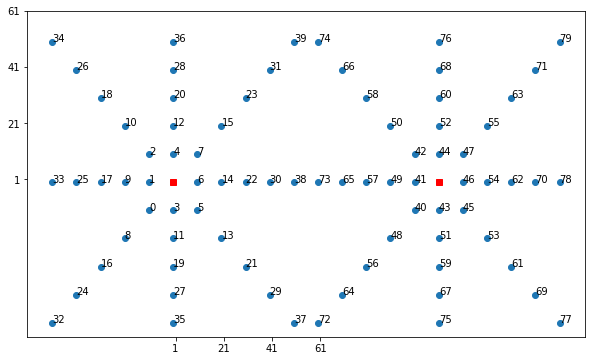

In [31]:
# --- PLOTA O GRAFICO ---
plt.figure(figsize=(10, 6))
plt.scatter(coord_x[0:], coord_y[0:])
for i in N:
    plt.annotate(f"{i}", (coord_x[i], coord_y[i]))
for i in D:
    plt.plot(coord_x[i], coord_y[i], c = 'r', marker = 's')

for i in V:
    for j in V:
        if x[i][j].x > 0:
            plt.plot([coord_x[i], coord_x[j]], [coord_y[i], coord_y[j]], c='g', zorder=0)
    
#escala dos eixos
plt.yticks([i for i in range(1,80,20)]); 
plt.xticks([i for i in range(1,80,20)]); 


In [32]:
# dist percorrida
sum([(1 if x[i][j].x>0.5 else 0) * c[i,j] for i in V for j in V if i != j])

0.0

In [33]:
# nao atendidos
[i for i in N if w[i].x < 0.5]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79]

In [34]:
# nro de veiculos
sum(x[k][i].x for k in D for i in N)

0.0

In [35]:
# cidades que tem mais de dois arcos ligadas a ela (depositos podem ter mais)
print([j for j in V if len([i for i in V if x[j][i].x > 0.5 or x[i][j].x > 0.5]) > 2])

[]


In [36]:
# [el.x for el in w]
# cidades nao atendidas
[i for (i, el) in enumerate(w) if el.x < 0.5]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79]